In [2]:
import pandas as pd
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.regularizers import L2
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import umap.umap_ as umap

In [3]:
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
np.random.seed(42)

In [ ]:
full_df = pd.read_csv('full_dataset.csv')
df = full_df["NER"]

In [ ]:
del full_df

In [5]:
# print(df.describe())
print(df.info())
# print(df.NER.nunique())
# print(df.shape)

<class 'pandas.core.series.Series'>
RangeIndex: 2231142 entries, 0 to 2231141
Series name: NER
Non-Null Count    Dtype 
--------------    ----- 
2231142 non-null  object
dtypes: object(1)
memory usage: 17.0+ MB
None


In [6]:
def make_into_item_list(s):
    s = s[1:-1]
    my_list = []
    substring = ''
    done = True
    my_set = {',',' '}
    for char in s:
        if char == '"':
            if done == True:
                done = False
                continue
            my_list.append(substring)
            substring = ''
            done = True
            continue
        elif char == ',':
            continue
        elif char == ' ':
            if done == True:
                continue
        elif char == '-':
            substring += ' '
            continue
        substring += char.lower()
    return my_list

def tokenize(ingredients):
    ingredient_cleaned = re.sub(r"[^\w\s]","",ingredients)
    tokens = word_tokenize(ingredient_cleaned)
    if len(tokens) <= 200000:
        return ingredient_cleaned
    return tokens

In [7]:
unique_items = dict()
i = 0
recipe_ingredients = []

for row in df[:200000]:
    item_list = make_into_item_list(row)
    for item in item_list:
        if item not in unique_items:
            unique_items[item] = 1
        else:
            unique_items[item] += 1
    tokenized_list = [tokenize(ingredient) for ingredient in item_list]
    recipe_ingredients.append(tokenized_list)
    i+=1
    
# print(row)
# print(make_into_item_list(row))
# print(set(make_into_item_list(row)))
# print(i)
# print(len(unique_items))
# print(len(recipe_ingredients))

In [8]:
w2v = Word2Vec(sentences=recipe_ingredients,vector_size=300,window=5,workers=4,min_count=5,sg=1)

In [9]:
w2v.save("ingredient_word2vec_1000.model")

In [10]:
model = Word2Vec.load("ingredient_word2vec_1000.model")

In [1]:
v = model.wv["butter"]
new_recipes = []
errors = []
issue_flag = False
recipe_vectors = []
for i in range(len(recipe_ingredients[:200000])):
    temp = []
    
    for ingredient in recipe_ingredients[i]:
        try:
            vector = model.wv[ingredient]
            norm = np.linalg.norm(vector)
            if norm == 0:
                normed_vector = vector/(1e-12)
            else:
                normed_vector = vector/ norm
            # temp.append(model.wv[ingredient])
            temp.append(normed_vector)
        except KeyError:
            # print(f"Key: {ingredient} not found")
            errors.append(recipe_ingredients[i])
            issue_flag = True
            break
            
    if issue_flag:
        issue_flag = False
        continue
        
    # new_recipes.append(temp)
    recipe_vectors.append(temp)
    
print(len(errors))
# print(new_recipes)
# print(np.linalg.norm(v/np.linalg.norm(v)))

NameError: name 'model' is not defined

In [ ]:
averaged_recipe_list = []
for recipe in recipe_vectors:
    res = np.mean(recipe,axis=0)
    if type(res) == np.float64 and math.isnan(res):
        continue
    else:
        averaged_recipe_list.append(res)


In [ ]:
inter_df = pd.DataFrame(averaged_recipe_list)
# # print(inter_df.head())
# # print(inter_df.shape())
# print(inter_df.shape)

In [ ]:
renamed = {}
for i in range(300):
    renamed[i] = f"{i}"
inter_df.rename(columns = renamed,inplace=True)

In [ ]:
inter_df.to_parquet('averaged_recipe_list_1000.parquet')
# averaged_recipe_list = pd.read_parquet('averaged_recipe_list.parquet')

In [ ]:
print(averaged_recipe_list.shape)
averaged_recipe_list = averaged_recipe_list[:200000]
print(averaged_recipe_list.shape)

In [ ]:
X_train, X_val = train_test_split(averaged_recipe_list,test_size = 0.2,random_state =42, shuffle=True)
#print(len(X_train[0]))
#print(X_test[:10])

In [ ]:
# comp = len(X_train[0])
# issues_in_size = []
# for thing in X_train:
#     if len(thing) != comp:
#         issues_in_size.append(thing)
# print(len(issues_in_size))
# i = 0
# for vector in averaged_recipe_list:
#     try:
#         if math.isnan(vector):
#             i += 1
#     except:
#         pass
# print(i)

In [36]:
l2_lambda = 0.01 # could try smaller or larger or dont include at all (and use dropout)
droprate = 0.3 # include or not include, could increase or decrease
# Encoder
input_vector = Input(shape=(100,))
# encoded = Dense(64, activation='relu', kernel_regularizer=L2(l2_lambda))(input_vector)
# encoded = Dense(32, activation='relu', kernel_regularizer=L2(l2_lambda))(encoded)
encoded = Dense(64, activation='relu')(input_vector)
latent = Dense(32, activation='relu')(encoded)
# latent = Dense(16, activation='relu')(encoded)  # could cut it to be latent at 32

# Decoder (symmetric to encoder)
# decoded = Dense(32, activation='relu', kernel_regularizer=L2(l2_lambda))(latent)
# decoded = Dense(64, activation='relu', kernel_regularizer=L2(l2_lambda))(decoded)
# decoded = Dense(32, activation='relu')(latent)
# decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(64, activation='relu')(latent)
output_vector = Dense(100, activation='linear')(decoded) # could switch to linear and see what happens (if normalization is not [0,1]

# Build the autoencoder model
autoencoder = Model(input_vector, output_vector)

# Compile the model
# autoencoder.compile(optimizer='adam', loss='mse',steps_per_execution=1)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='mse',
                    steps_per_execution=1)

# Summary of the model architecture
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,156 (67.02 KB)

 Trainable params: 17,156 (67.02 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# X_train_v1 = np.array(X_train[:100])
# X_val_v1 = np.array(X_val[:100])
X_train_v1 = np.array(X_train)
X_val_v1 = np.array(X_val)
X_train_v1 = tf.convert_to_tensor(X_train_v1)
X_val_v1 = tf.convert_to_tensor(X_val_v1)

# print(type(X_train[0]))


In [17]:
# xv1 = np.stack(X_train_v1)  # Shape: (num_samples, ...)
# xv2 = tf.data.Dataset.from_tensor_slices(xv1)

# # Configure batching, shuffling, etc.
# xv2 = xv2.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)

# xvv1 = np.stack(X_val_v1)  # Shape: (num_samples, ...)
# xvv2 = tf.data.Dataset.from_tensor_slices(xvv1)

# # Configure batching, shuffling, etc.
# xvv2 = xvv2.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)

In [41]:
history = autoencoder.fit(
    X_train_v1, X_train_v1,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_v1, X_val_v1),
    verbose=1
)
# history = autoencoder.fit(
#     xv2, xv2,
#     epochs=5,
#     batch_size=128,
#     validation_data=(xvv2,xvv2),
#     verbose=1
# )

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 6.3678e-04 - val_loss: 5.4206e-04
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 5.2267e-04 - val_loss: 4.7970e-04
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 4.7692e-04 - val_loss: 4.6271e-04
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 4.7137e-04 - val_loss: 4.9033e-04
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 5.0805e-04 - val_loss: 5.4072e-04


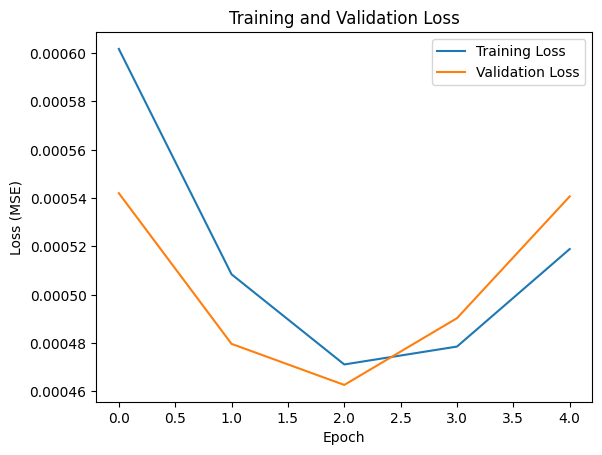

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

In [47]:
save_model(autoencoder,'autoencoder_model_cuslr_linear_e5_b64_10pv.keras')

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


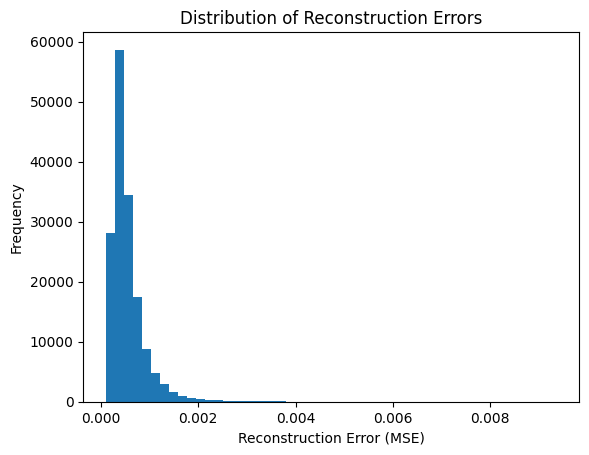

In [44]:
n_samples = 5
# test_samples = np.array(X_train_v1)[:n_samples]
test_samples = np.array(X_train_v1)
# test_samples = np.random.choice(np.array(X_train_v1),size=(5))

reconstructed_samples = autoencoder.predict(test_samples)
# fig, axes = plt.subplots(n_samples, 2, figsize=(8, 2 * n_samples))

# for i in range(n_samples):
#     axes[i, 0].imshow(test_samples[i].reshape(1,100), cmap="gray")  # Modify shape for your data
#     axes[i, 0].set_title("Original")
#     axes[i, 0].axis("off")

#     axes[i, 1].imshow(reconstructed_samples[i].reshape(1, 100), cmap="gray")  # Modify shape for your data
#     axes[i, 1].set_title("Reconstructed")
#     axes[i, 1].axis("off")

# plt.tight_layout()
# plt.show()

# Flatten the input and output for comparison
X_test_flat = np.array(X_train_v1).reshape(len(X_train_v1), -1)
recon_flat = reconstructed_samples.reshape(len(reconstructed_samples), -1)

# Compute MSE for each sample
mse_scores = np.mean(np.square(X_test_flat - recon_flat), axis=1)

# Plot distribution of MSE
plt.hist(mse_scores, bins=50)
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


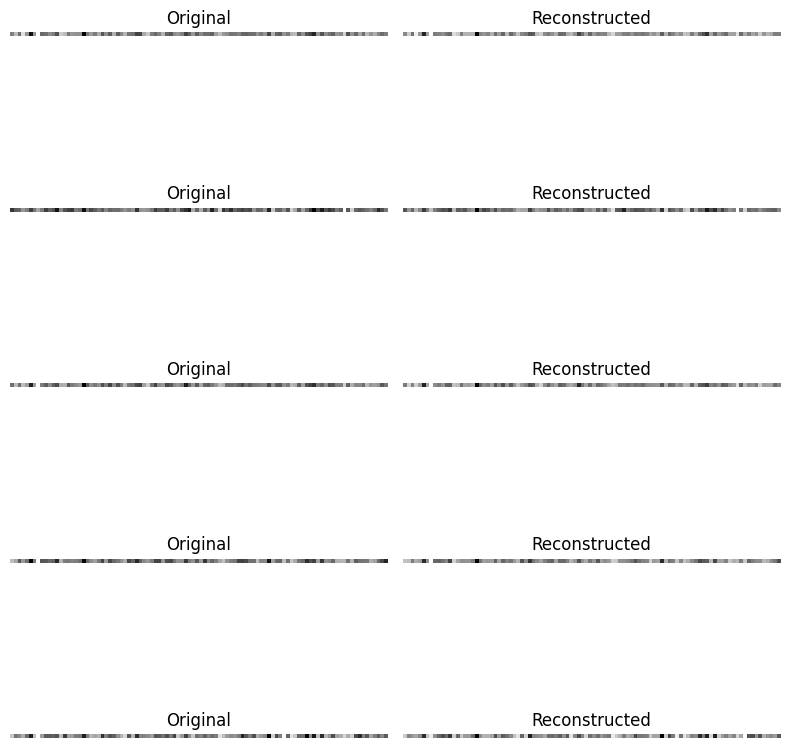

[ 6.5307207e-03  1.0409558e-01 -2.2762494e-02  1.6767696e-01
  3.8492922e-02 -1.7833477e-01  4.4450015e-02  2.1703379e-01
 -3.0755360e-02 -1.5304452e-02  2.6777687e-02  1.1778902e-05
 -6.8262920e-02  1.3203616e-01  1.0363208e-01 -4.3176059e-03
  4.5386571e-02  3.7673075e-02  3.5134941e-02 -2.0402205e-01
 -6.1430028e-03  5.1568441e-02  6.9423206e-04  7.9448715e-02
 -6.2529303e-02  3.2148503e-02 -4.9314827e-02  8.5344233e-02
 -4.8377298e-02  1.9659040e-02  9.1855496e-02 -1.0199307e-02
 -2.0564217e-02 -9.5491670e-02 -8.9957394e-02  7.2650582e-02
  1.2350830e-01  3.5567982e-03 -3.0440230e-02  9.1379974e-03
  8.7203689e-02 -3.8024399e-02 -5.5639669e-02  2.7207524e-02
  4.3961190e-02  7.8171603e-03 -9.3449779e-02 -4.0527090e-02
  4.6260625e-02 -4.6953432e-02  2.1544175e-02 -1.9910103e-02
 -2.0888828e-02 -3.9812990e-02  5.8119569e-02  1.0606370e-01
  4.7579948e-02  2.9924940e-02 -1.1973898e-02 -5.7360884e-03
  1.4503175e-02 -3.7227023e-02 -3.7139129e-02 -2.4480190e-02
 -2.0760564e-02  3.93051

In [45]:
n_samples = 5
test_samples = np.array(X_train_v1)[np.random.choice(len(X_train_v1),n_samples, replace=False)]

reconstructed_samples = autoencoder.predict(test_samples)
fig, axes = plt.subplots(n_samples, 2, figsize=(8, 2 * n_samples))

for i in range(n_samples):
    axes[i, 0].imshow(test_samples[i].reshape(1,100), cmap="gray")  # Modify shape for your data
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(reconstructed_samples[i].reshape(1, 100), cmap="gray")  # Modify shape for your data
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
for i in range(len(test_samples)):
    print(test_samples[i])
    print(reconstructed_samples[i])
    print()
    

In [49]:
# print(np.array(X_train_v1.shape))
autoencoder = tf.keras.models.load_model('autoencoder_model_cuslr_linear_e5_b64_10pv.keras')
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,470 (201.06 KB)

 Trainable params: 17,156 (67.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,314 (134.04 KB)

In [51]:
# latent_layer = autoencoder.get_layer('dense_33')
latent_layer = autoencoder.get_layer('dense_9')
encoder = Model(inputs=autoencoder.input, outputs=latent_layer.output)

In [52]:
latent_representation = encoder.predict(X_train_v1,batch_size=32)

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [53]:
# print(latent_representation.shape)
# print(latent_representation[0])

In [54]:
k_values = range(2, 101)  # from 2 to 10 clusters

wcss = []  # List to store within-cluster sum of squares
silhouette_scores = []  # List to store silhouette scores
sample_size = 50000
for k in k_values:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(latent_representation)
    wcss.append(kmeans.inertia_)  # inertia is the WCSS
    print("Done KMeans")
    # Calculate silhouette score only if k > 1
    if k > 1:
        score = silhouette_score(latent_representation, kmeans.labels_,sample_size=sample_size,random_state=42)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(None)
    print("Done Score and round")

2
Done KMeans
Done Score and round
3
Done KMeans
Done Score and round
4
Done KMeans
Done Score and round
5
Done KMeans
Done Score and round
6
Done KMeans
Done Score and round
7
Done KMeans
Done Score and round
8
Done KMeans
Done Score and round
9
Done KMeans
Done Score and round
10
Done KMeans
Done Score and round
11
Done KMeans
Done Score and round
12
Done KMeans
Done Score and round
13
Done KMeans
Done Score and round
14
Done KMeans
Done Score and round
15
Done KMeans
Done Score and round
16
Done KMeans
Done Score and round
17
Done KMeans
Done Score and round
18
Done KMeans
Done Score and round
19
Done KMeans
Done Score and round
20
Done KMeans
Done Score and round
21
Done KMeans
Done Score and round
22
Done KMeans
Done Score and round
23
Done KMeans
Done Score and round
24
Done KMeans
Done Score and round
25
Done KMeans
Done Score and round
26
Done KMeans
Done Score and round
27
Done KMeans
Done Score and round
28
Done KMeans
Done Score and round
29
Done KMeans
Done Score and round


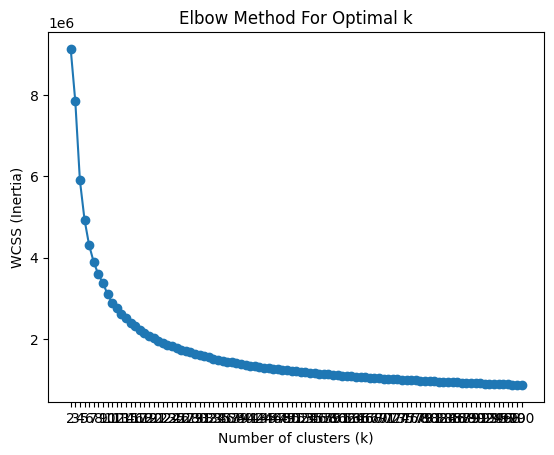

In [55]:
plt.plot(list(k_values), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(list(k_values))
plt.show()

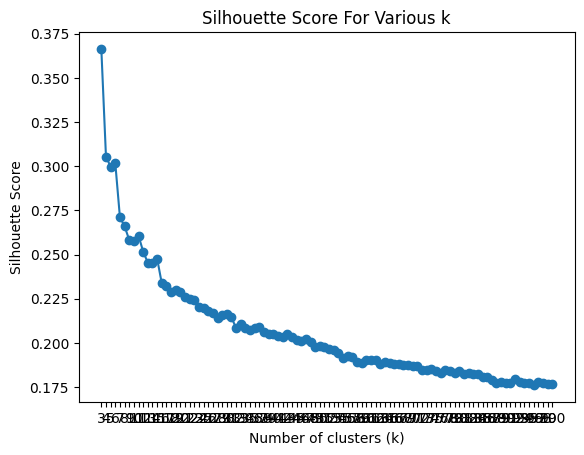

[0.54229635, 0.3663391, 0.305425, 0.2997112, 0.301807, 0.27113283, 0.2660469, 0.25831866, 0.25780603, 0.26069793, 0.25171643, 0.24542664, 0.24545322, 0.24778572, 0.233839, 0.2319799, 0.22859854, 0.22993796, 0.22869785, 0.22586857, 0.22473316, 0.22458485, 0.22061631, 0.21974353, 0.21792196, 0.2167143, 0.21438904, 0.21599826, 0.21630578, 0.21445973, 0.20835422, 0.21057351, 0.20873252, 0.20711716, 0.20832072, 0.20910236, 0.20640227, 0.20530002, 0.20534693, 0.20378728, 0.20321961, 0.204968, 0.20354715, 0.20141616, 0.20097326, 0.20235123, 0.20063628, 0.1976089, 0.19852462, 0.19762424, 0.1964789, 0.19628726, 0.19430748, 0.19174041, 0.19281821, 0.1920958, 0.18951713, 0.18884027, 0.1904943, 0.19052842, 0.19048329, 0.18824174, 0.18945362, 0.18842596, 0.18814173, 0.1881092, 0.1875227, 0.18744487, 0.18723555, 0.18681143, 0.18487342, 0.18455379, 0.18500428, 0.18415163, 0.18292929, 0.18480426, 0.18389072, 0.18281643, 0.18396026, 0.18262687, 0.18278843, 0.18241195, 0.18219195, 0.18064533, 0.18093649

In [56]:
plt.plot(list(k_values)[1:], silhouette_scores[1:], marker='o')  # starting at k=2
plt.title('Silhouette Score For Various k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(list(k_values)[1:])
plt.show()
print(silhouette_scores,wcss)

In [59]:
kmeans_rep = KMeans(n_clusters=2,random_state=42)
kmeans_rep.fit(latent_representation)
cluster_labels = kmeans_rep.labels_
# print(cluster_labels.shape)

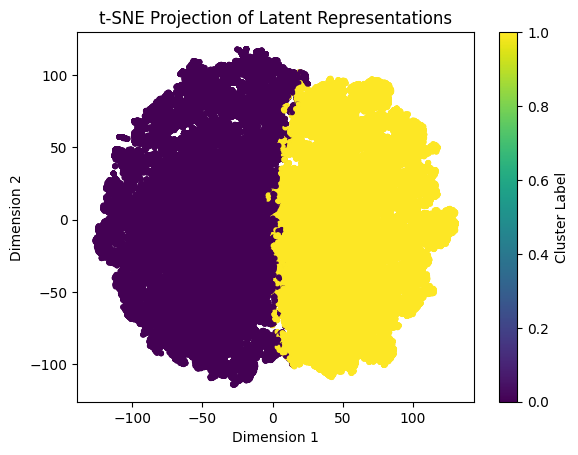

655.704596042633


In [60]:
start = time.time()
num_samples = latent_representation.shape[0]
# sample_size = 200000
# sample_size = 199999
# sample_indices = np.random.choice(num_samples, sample_size, replace=False)
# latent_sample = latent_representation[sample_indices]
latent_sample = latent_representation
labels_sample = cluster_labels

# Set up t-SNE to project the latent vectors to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(latent_sample)

# Plot the t-SNE results, color-coded by cluster labels
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                      c=labels_sample, cmap='viridis', s=10)
plt.colorbar(scatter, label='Cluster Label')
plt.title("t-SNE Projection of Latent Representations")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
end = time.time()
plt.show()
print(end-start)

In [11]:

# Perform K-Means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(latent_representation)


In [ ]:
start = time.time()
# Set up UMAP to project the latent representations to 2D
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(latent_representation)

# Plot the UMAP projection, color-coded by the cluster labels from K-Means
scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1],
                      c=clusters, cmap='viridis', s=5)
plt.colorbar(scatter, label='Cluster Label')
plt.title("UMAP Projection of Latent Representations (k=2)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
end = time.time()
plt.show()
print(end-start)

/opt/anaconda3/envs/final_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/final_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/final_env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[4.35527041e-15 3.21045878e-07 6.74308205e-07 2.43576204e-05]
not reaching the requested tolerance 2.3692846298217773e-06.
Use iteration 1677 instead with accuracy 
1.2391699555271979e-06.

  _, diffusion_map = lobpcg(
/opt/anaconda3/envs/final_env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[3.53264481e-15 2.55195071e-07 4.13736712e-07 4.28774480e-06]
not r